# hep stats hello world

Ryan Reece <https://github.com/rreece>        
created: 2020-07-09

## TODO:

-   ~~Revist conventions for storing results of hypo tests: `CLs_obs, CLs_exp_band`~~
-   ~~Clean up function above for plotting mu excluded vs one theoretical param.~~
-   ~~Write Z-peak-like example.~~
-   ~~Try ToyCalculator instead of AsymptoticCalculator.~~
-   ~~Generate data with injected signal.~~
-   ~~Fix hep.plot.hist1d ylim default range.~~
-   Fix for handeling the total number of events; extended maximum likelihood.
-   Write functions for showing hists pre and post fit.
-   Understand what [pyhf.infer.hypotest](https://scikit-hep.org/pyhf/_generated/pyhf.infer.hypotest.html) does in detail.
-   Understand where all the implicit fitting and computation is and document it. Time the execution of parts.
-   ~~Calculate p_0 for discovery.~~
-   ~~Write a 2-sided measurement of signal with t_mu.~~
-   Re-use bkg toys in case of ToyCalculator.
-   How to add systematics in pyhf?
-   Remind myself and understand the interpolations used.
-   Side-band analysis of fakes, ABCD.
-   Add splining option to hep.plot.brazil.
-   Write a function for plotting an exclusion contour in 2-D theoretical paramter space.
-   https://stackoverflow.com/questions/64538170/using-pyhf-to-float-both-signal-and-background-strength

In [1]:
import json
import math
import numpy as np
import pyhf

import scipy
from scipy.stats import cauchy, truncexpon
import matplotlib.pyplot as plt

import hepplot as hep

In [2]:
pyhf.__version__

'0.7.0'

In [3]:
pyhf.get_backend()

(<pyhf.tensor.numpy_backend.numpy_backend at 0x7f4c01c6ae00>,
 <pyhf.optimize.scipy_optimizer at 0x7f4c01c5bea0>)

In [4]:
np.__version__

'1.22.3'

In [5]:
np.random.seed(2)

TODO: following

-    [multichannel-coupled-histo.html](https://scikit-hep.org/pyhf/examples/notebooks/multichannel-coupled-histo.html)
-    [2bin_2channel_coupledhisto.json](https://github.com/scikit-hep/pyhf/blob/master/validation/data/2bin_2channel_coupledhisto.json)

In [6]:
sourcedata = {
  "channels": {
    "signal": {
      "binning": [2, -0.5, 1.5],
      "bindata": {
        "data":       [170.0, 220.0],
        "bkg1":       [100.0, 100.0],
        "bkg1_up":    [110.0, 110.0],
        "bkg1_dn":      [90.0, 90.0],
        "bkg2":        [50.0, 120.0],
        "bkg2_up":     [55.0, 55.0],
        "bkg2_dn":     [45.0, 45.0],
        "sig":          [30.0, 35.0]
      }
    },
    "control": {
      "binning": [2, -0.5, 1.5],
      "bindata": {
        "data":     [110.0, 105.0],
        "bkg1":     [105.0, 100.0],
        "bkg1_up":  [110.0, 115.0],
        "bkg1_dn":    [95.0, 90.0]
      }
    }
  }
}

In [7]:
def prep_data(sourcedata):
    spec = {
        "channels": [
            {
                "name": "signal",
                "samples": [
                    {
                        "name": "signal",
                        "data": sourcedata["signal"]["bindata"]["sig"],
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "bkg1",
                        "data": sourcedata["signal"]["bindata"]["bkg1"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["signal"]["bindata"][
                                        "bkg1_dn"
                                    ],
                                    "hi_data": sourcedata["signal"]["bindata"][
                                        "bkg1_up"
                                    ],
                                },
                            }
                        ],
                    },
                    {
                        "name": "bkg2",
                        "data": sourcedata["signal"]["bindata"]["bkg2"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["signal"]["bindata"][
                                        "bkg2_dn"
                                    ],
                                    "hi_data": sourcedata["signal"]["bindata"][
                                        "bkg2_up"
                                    ],
                                },
                            }
                        ],
                    },
                ],
            },
            {
                "name": "control",
                "samples": [
                    {
                        "name": "background",
                        "data": sourcedata["control"]["bindata"]["bkg1"],
                        "modifiers": [
                            {
                                "name": "coupled_histosys",
                                "type": "histosys",
                                "data": {
                                    "lo_data": sourcedata["control"]["bindata"][
                                        "bkg1_dn"
                                    ],
                                    "hi_data": sourcedata["control"]["bindata"][
                                        "bkg1_up"
                                    ],
                                },
                            }
                        ],
                    }
                ],
            },
        ]
    }
    pdf = pyhf.Model(spec)
    data = []
    for c in pdf.spec["channels"]:
        data += sourcedata[c["name"]]["bindata"]["data"]
    data = data + pdf.config.auxdata
    return data, pdf

In [8]:
json_filename = "2bin_2channel_coupledhisto.json"
source = json.load(open(json_filename))
data, pdf = prep_data(source["channels"])

In [9]:
data

[170.0, 220.0, 110.0, 105.0, 0.0]

## Main parameters

In [10]:
LUMI = 2.0

In [11]:
x_min = 80.
x_max = 180.
n_xbins = 20
xlabel = '$m\ \ [\mathrm{GeV}]$'
ylabel = '$dN/dm\ /\ (5\ \mathrm{GeV})$'

In [12]:
## normal params
mu_bounds_excl = (0, 5)
mu_step_excl = 0.1
test_size = 0.05
mu_bounds_fit = (-0.5, 2.0)
mu_step_fit = 0.05

In [13]:
## fine params
#mu_bounds_excl = (0, 4)
#mu_step_excl = 0.05
#test_size = 0.05
#mu_bounds_fit = (-0.5, 2.0)
#mu_step_fit = 0.025

## Setup the theory

In [14]:
# background params
m_Z = 91.2
gamma_Z = 2.5
func_Z = cauchy(loc=m_Z, scale=gamma_Z)
sigma_Z = 9000.

In [15]:
loc_fakes = x_min
scale_fakes = 100.
b_fakes = x_max
func_fakes = truncexpon(b_fakes, loc=loc_fakes, scale=scale_fakes)
sigma_fakes = 1000.

In [16]:
## signal params
signal_masses = [110., 130., 150., 170.]
#signal_masses = [110., 120., 130., 140., 150., 160., 170.]
max_signals_plotted = 4

## fine params
#signal_masses = [110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170., 175.]
#max_signals_plotted = 8

In [17]:
sigma_tot = sigma_Z + sigma_fakes
f_Z = sigma_Z / sigma_tot
f_fakes = sigma_fakes / sigma_tot
bkg_sigmas = [sigma_Z, sigma_fakes]

In [18]:
signal_labels = ['$s_{%i}$' % (m) for m in signal_masses ]
signal_widths = [ 0.02*m for m in signal_masses ]
signal_funcs = [ cauchy(loc=m, scale=w) for m, w in zip(signal_masses, signal_widths) ]
signal_sigmas = [ 150. - 0.5*m for m in signal_masses ]
i_signal_injected = signal_masses.index(150.)

In [19]:
signal_sigmas

[95.0, 85.0, 75.0, 65.0]

In [20]:
# define pdfs and normalize them over linspace x
x = np.linspace(x_min, x_max, n_xbins)
pdf_Z = func_Z.pdf(x)
pdf_fakes = func_fakes.pdf(x)
n_Z = sum(pdf_Z)
n_fakes = sum(pdf_fakes)
pdf_Z = pdf_Z / n_Z
pdf_fakes = pdf_fakes / n_fakes
pdf_tot1 = f_Z*pdf_Z + f_fakes*pdf_fakes
assert np.allclose(sum(pdf_Z), 1.0)
assert np.allclose(sum(pdf_fakes), 1.0)
assert np.allclose(sum([f_Z, f_fakes]), 1.0)
assert np.allclose(sum(pdf_tot1), 1.0)

In [21]:
f_Z

0.9

In [22]:
f_fakes

0.1

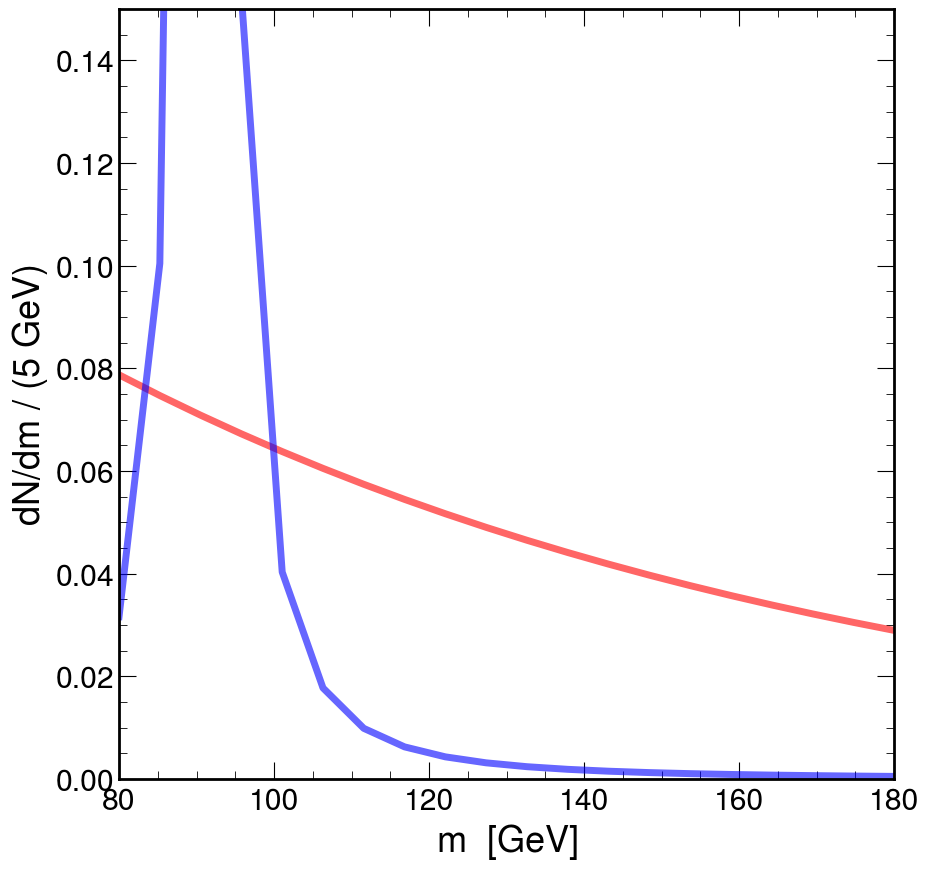

In [23]:
fig, ax = plt.subplots(1, 1)
xlims=(x_min, x_max)
ylims=(0.0, 0.15)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.plot(x, pdf_fakes, 'r-', lw=5, alpha=0.6, label='fakes')
ax.plot(x, pdf_Z, 'b-', lw=5, alpha=0.6, label='Z')

In [24]:
# make DataGenerator with mixture of pdfs
bkg_funcs = [func_Z, func_fakes]
bkg_mixtures = [f_Z, f_fakes]
bkg_gen = hep.data.DataGenerator(funcs=bkg_funcs, mixtures=bkg_mixtures)
bkg_pdf = bkg_gen.get_pdf(x)
assert np.allclose(bkg_pdf, pdf_tot1)

In [25]:
sig_gens = [ hep.data.DataGenerator(funcs=[_func], mixtures=[1.0]) for _func in signal_funcs ]

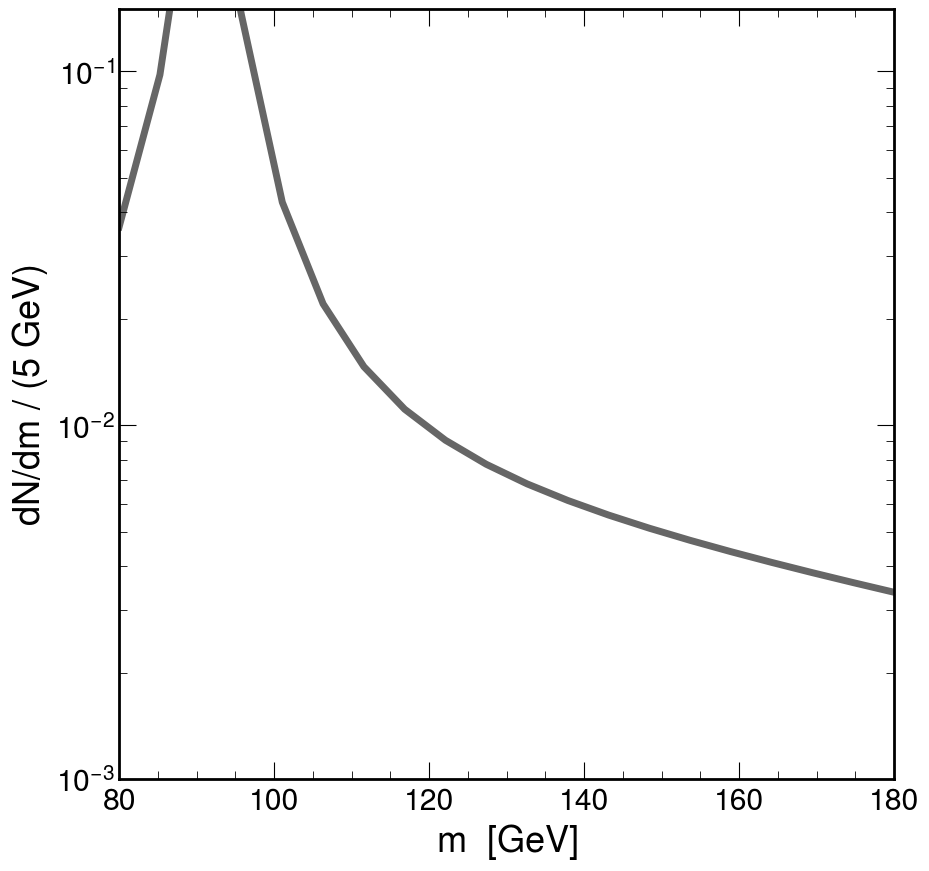

In [26]:
fig, ax = plt.subplots(1, 1)
xlims=(x_min, x_max)
#ylims=(0.0, 0.15)
ylims=(1e-3, 0.15) # logy
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_yscale('log')
ax.plot(x, bkg_pdf, 'k-', lw=5, alpha=0.6, label='pdf')

## Monte Carlo for the model

In [27]:
a_test = bkg_gen.generate(1000, i=1)
y_test = np.histogram(a_test, bins=n_xbins, range=(x_min, x_max))

In [28]:
y_test

(array([42, 44, 49, 41, 51, 37, 39, 38, 34, 35, 25, 48, 27, 30, 21, 32, 20,
        18, 16, 17]),
 array([ 80.,  85.,  90.,  95., 100., 105., 110., 115., 120., 125., 130.,
        135., 140., 145., 150., 155., 160., 165., 170., 175., 180.]))

In [29]:
bins = list(y_test[1])

In [30]:
n_bkgs = bkg_gen.get_n()
assert len(bkg_sigmas) == n_bkgs
n_mcs = [int(1e5), int(1e5)]
bkg_hists = [ np.histogram(bkg_gen.generate(n_mcs[_i], i=_i), bins=n_xbins, range=(x_min, x_max))[0] for _i in range(n_bkgs)]
bkg_scales = [ bkg_sigmas[_i]*LUMI/n_mcs[_i] for _i in range(n_bkgs) ]
bkg_hists = [ list(bkg_hists[_i] * bkg_scales[_i]) for _i in range(n_bkgs) ]


In [31]:
bins = [ float(_b) for _b in y_test[1] ]
y = bkg_hists
xlabel = '$m$  [GeV]'
ylabel = 'Events / (5 GeV)'
labels = ['Z','Fakes']
ytotal  = [sum(_y) for _y in zip(*y)]

## gaussian errors
yerr    = [
    math.sqrt(_y) for _y in ytotal
]
# TODO: yerr should be better that sqrt(n)

In [32]:
n_signals = [ int(round(s*LUMI)) for s in signal_sigmas ]
signal_grid = dict()
for _m, _sg, _n in zip(signal_masses, sig_gens, n_signals):
    _x = _sg.generate(_n)
    signal_grid[(_m,)] = list(np.histogram(_x, bins=n_xbins, range=(x_min, x_max))[0])

In [33]:
signal_points = list(signal_grid.keys())
signal_points.sort()
signals = [signal_grid[k] for k in signal_points]

In [34]:
n_data = int(round(sigma_tot*LUMI))
data = list(np.histogram(bkg_gen.generate(n_data), bins=n_xbins, range=(x_min, x_max))[0])
data_label='Data'

## Histograms

(<Figure size 1000x1000 with 2 Axes>,
 [<AxesSubplot: ylabel='Events / (5 GeV)'>,
  <AxesSubplot: xlabel='$m$  [GeV]'>])

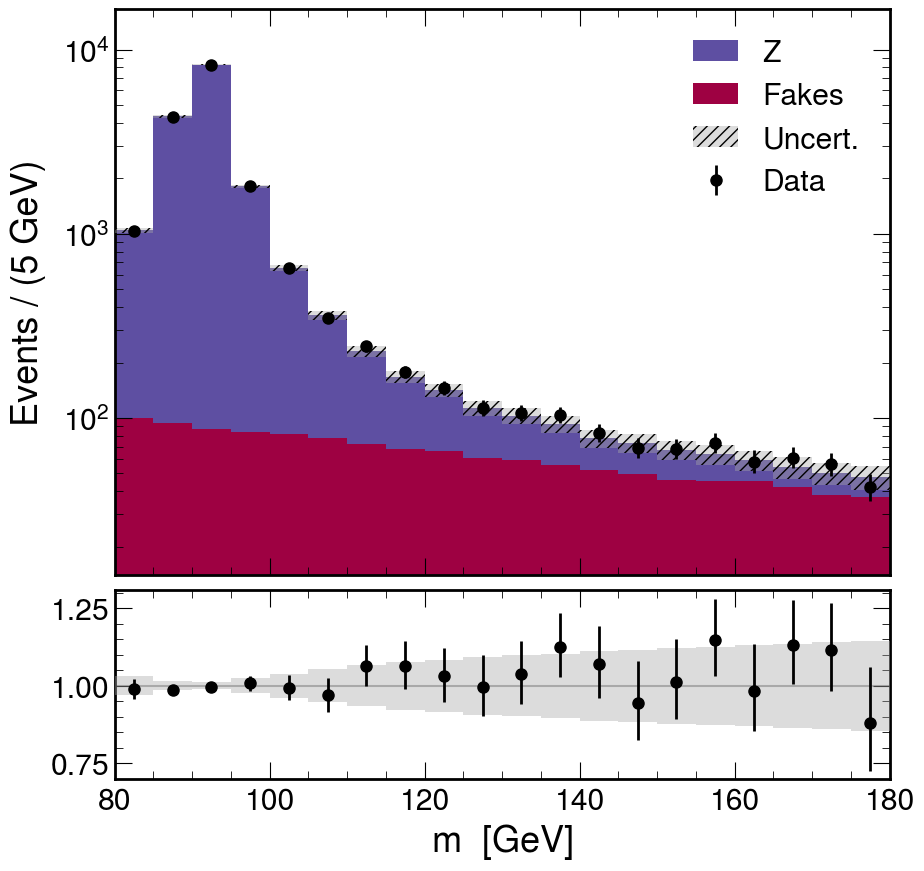

In [35]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data,
                data_label=data_label,
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(x_min, x_max),
#                ylim=(10., 1e4),
                yscale='log',
                ratio=True)

(<Figure size 1000x1000 with 2 Axes>,
 [<AxesSubplot: ylabel='Events / (5 GeV)'>,
  <AxesSubplot: xlabel='$m$  [GeV]'>])

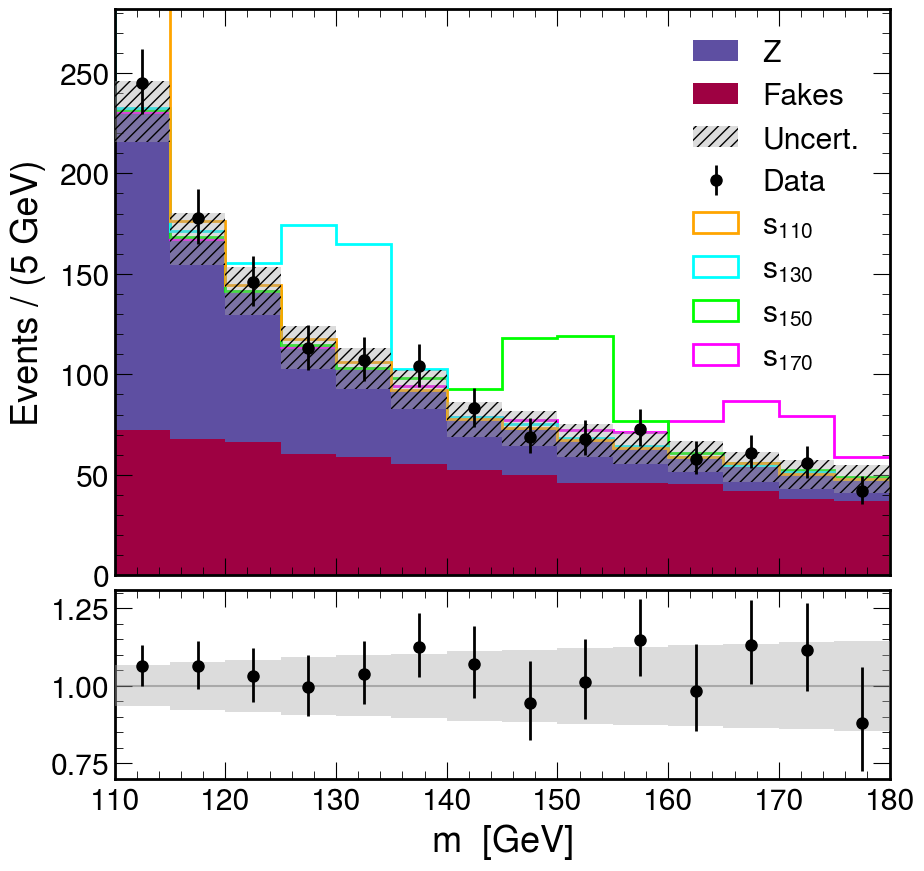

In [36]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data,
                data_label=data_label,
                signals=signals[-max_signals_plotted:],
                signal_labels=signal_labels[-max_signals_plotted:],
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(110, 180),
#                ylim=(0.0, 160.0),
                ratio=True,
                stack_signals=True)

## Hypothesis testing with pyhf

### TODO:

-   Explain `pyhf.simplemodels.hepdata_like`
    -   Marked Poisson
    -   Cranmer, K. et al. (2012). HistFactory: A tool for creating statistical models for use with RooFit and RooStats. CERN-OPEN-2012-016. <https://cds.cern.ch/record/1456844>

## Basic hypothesis test at mu=1.0

In [37]:
list_of_results = list()
for i_signal, signal in enumerate(signals[-max_signals_plotted:]):
    print('Testing signal %i' % (i_signal+1))
    pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signal)
    CLs_obs, CLs_exp_band = hep.stats.hypo_test(pdf=pdf, data=data, mu=1.0)
    results = dict()
    results['pdf'] = pdf
    results['CLs_obs'] = CLs_obs
    results['CLs_exp_band'] = CLs_exp_band
    list_of_results.append(results)
    print('Expected CLs -2 sigma: %.4f' % (CLs_exp_band[0]))
    print('Expected CLs -1 sigma: %.4f' % (CLs_exp_band[1]))
    print('Expected CLs         : %.4f' % (CLs_exp_band[2]))
    print('Expected CLs +1 sigma: %.4f' % (CLs_exp_band[3]))
    print('Expected CLs +2 sigma: %.4f' % (CLs_exp_band[4]))
    print('Observed CLs         : %.4f' % (CLs_obs))
    print('')

Testing signal 1
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0000
Expected CLs +1 sigma: 0.0005
Expected CLs +2 sigma: 0.0094
Observed CLs         : 0.0001

Testing signal 2
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0000
Expected CLs +1 sigma: 0.0000
Expected CLs +2 sigma: 0.0000
Observed CLs         : 0.0000

Testing signal 3
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0000
Expected CLs +1 sigma: 0.0000
Expected CLs +2 sigma: 0.0000
Observed CLs         : 0.0000

Testing signal 4
Expected CLs -2 sigma: 0.0000
Expected CLs -1 sigma: 0.0000
Expected CLs         : 0.0000
Expected CLs +1 sigma: 0.0002
Expected CLs +2 sigma: 0.0041
Observed CLs         : 0.0001



In [38]:
help(pyhf.simplemodels.uncorrelated_background)

Help on function uncorrelated_background in module pyhf.simplemodels:

uncorrelated_background(signal, bkg, bkg_uncertainty, batch_size=None, validate=True)
    Construct a simple single channel :class:`~pyhf.pdf.Model` with a
    :class:`~pyhf.modifiers.shapesys` modifier representing an uncorrelated
    background uncertainty.
    
    Example:
        >>> import pyhf
        >>> pyhf.set_backend("numpy")
        >>> model = pyhf.simplemodels.uncorrelated_background(
        ...     signal=[12.0, 11.0], bkg=[50.0, 52.0], bkg_uncertainty=[3.0, 7.0]
        ... )
        >>> model.schema
        'model.json'
        >>> model.config.channels
        ['singlechannel']
        >>> model.config.samples
        ['background', 'signal']
        >>> model.config.parameters
        ['mu', 'uncorr_bkguncrt']
        >>> model.expected_data(model.config.suggested_init())
        array([ 62.        ,  63.        , 277.77777778,  55.18367347])
    
    Args:
        signal (:obj:`list`): The data

In [39]:
pdf.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 4, 5, 8, 18, 33, 29, 11],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background',
     'data': [1047.74,
      4338.14,
      8298.359999999999,
      1808.94,
      653.5799999999999,
      360.24,
      230.57999999999998,
      167.16,
      141.64,
      113.38,
      103.03999999999999,
      92.42,
      77.64,
      73.12,
      67.14,
      63.54,
      58.94,
      53.900000000000006,
      50.220000000000006,
      47.739999999999995],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [32.368812149969294,
        65.86455799593587,
        91.09533467746851,
        42.531635284808885,
        25.565210736467634,
        18.979989462589277,
        15.184860881812517,
        12.929037087115189,
        11.901260437449471,
        10.648004507887851,
        10.15086203

## Hypothesis test scan for a single signal

In [40]:
first_signal_pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=signals[0])
cls_obs, cls_exp, test_mus = hep.stats.hypo_test_mu_scan(pdf=first_signal_pdf, 
                                                      data=data, 
                                                      mu_bounds=mu_bounds_excl,
                                                      mu_step=mu_step_excl)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: xlabel='$\\mu$', ylabel='$\\mathrm{CLs}$'>)

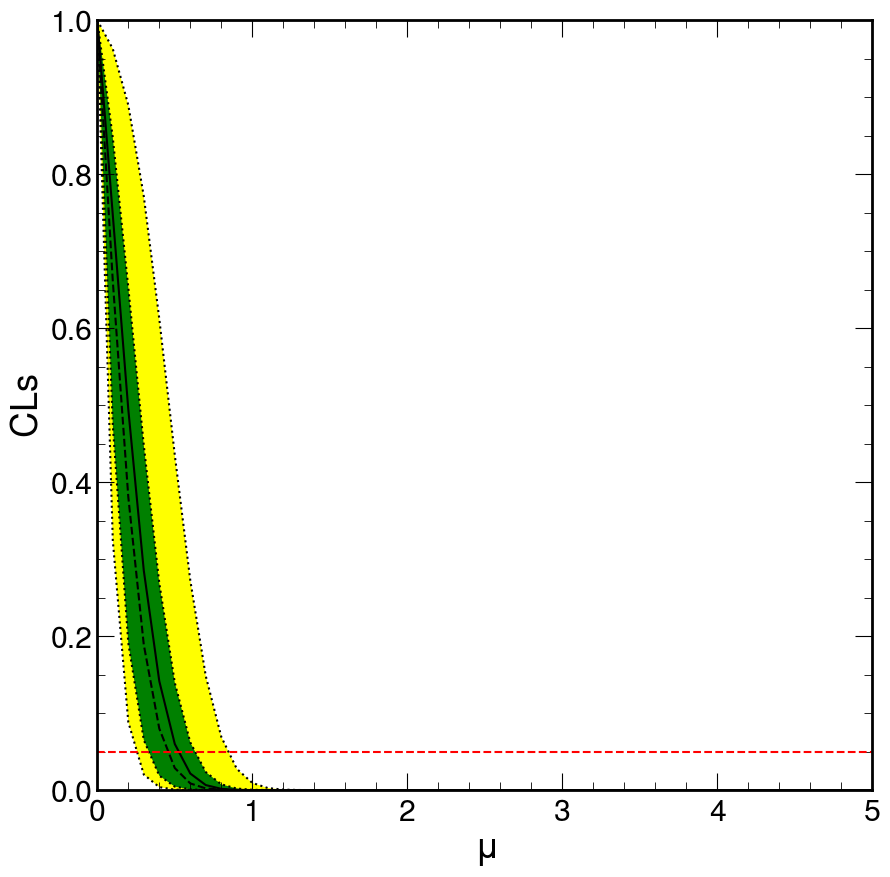

In [41]:
hep.plot.brazil(x=test_mus, exp=cls_exp, obs=cls_obs,
                     xlabel=r'$\mu$',
                     ylabel=r'$\mathrm{CLs}$',
                     xlim=mu_bounds_excl,
                     ylim=(0.0, 1.0),
                     yline=test_size)

In [42]:
hep.stats.invert_interval(cls_obs, cls_exp, test_mus, test_size=test_size)

(0.5258577935190489,
 [0.25633312832725796,
  0.3325713166530891,
  0.45831699979406554,
  0.6310922829037655,
  0.8461270956057512])

## Hypothesis test scan across signals

In [43]:
signal_ms, exclusions_exp, exclusions_obs = hep.stats.hypo_test_signal_scan(
        signal_grid=signal_grid,
        data=data,
        bkg_data=ytotal,
        bkg_uncerts=yerr,
        mu_bounds=mu_bounds_excl,
        mu_step=mu_step_excl,
        test_size=test_size)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: xlabel='$m$  [GeV]', ylabel='$\\mu\\ \\mathrm{excluded\\ at\\ 95\\%\\ CL}$'>)

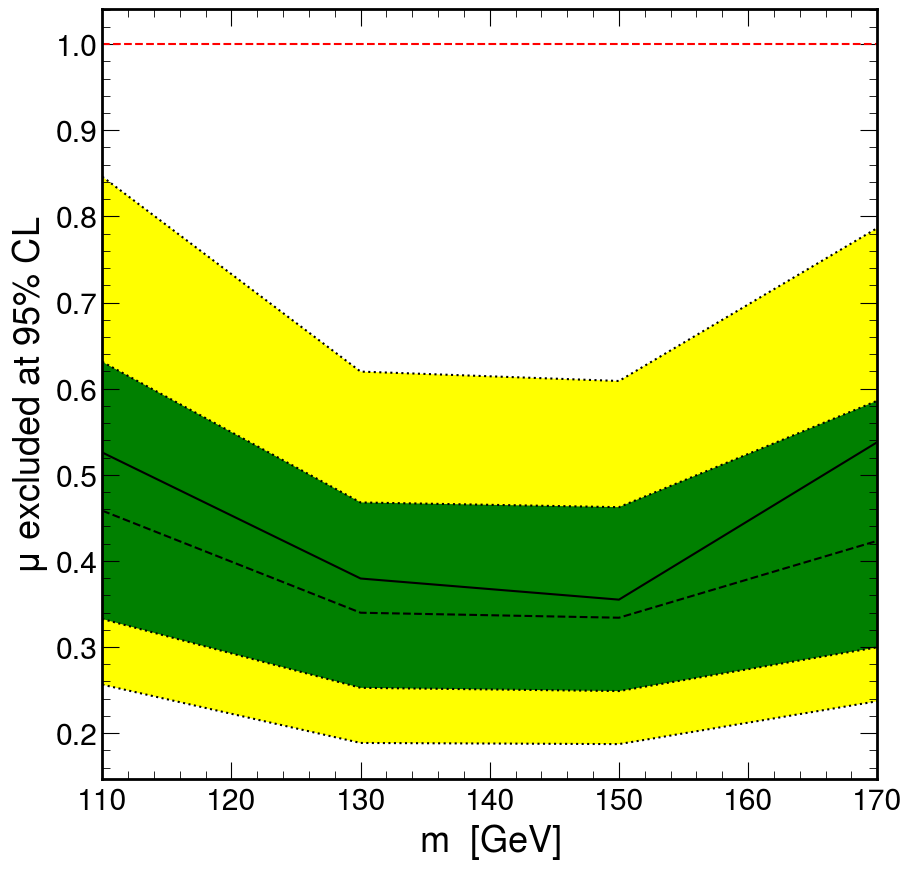

In [44]:
hep.plot.brazil(x=signal_ms, exp=exclusions_exp, obs=exclusions_obs,
                xlabel=r'$m$  [GeV]',
                ylabel=r'$\mu\ \mathrm{excluded\ at\ 95\%\ CL}$',
                yline=1.0)

## Injecting signal

In [45]:
sig_func = signal_funcs[i_signal_injected]
sig_sigma = signal_sigmas[i_signal_injected]
injection_funcs = bkg_funcs + [sig_func]
pdf_sig = sig_func.pdf(x)

sigma_tot2 = sigma_Z + sigma_fakes + sig_sigma
f_Z2 = sigma_Z / sigma_tot2
f_fakes2 = sigma_fakes / sigma_tot2
f_sig2 = sig_sigma / sigma_tot2

injection_mixtures = [f_Z2, f_fakes2, f_sig2]
pdf_tot2 = f_Z2*pdf_Z + f_fakes2*pdf_fakes + f_sig2*pdf_sig
injection_gen = hep.data.DataGenerator(funcs=injection_funcs, mixtures=injection_mixtures)

In [46]:
injection_mixtures

[0.8933002481389578, 0.09925558312655088, 0.007444168734491315]

In [47]:
sigma_tot2, sigma_Z, sigma_fakes, sig_sigma

(10075.0, 9000.0, 1000.0, 75.0)

In [48]:
n_data2 = int(round(sigma_tot2*LUMI))
data2 = list(np.histogram(injection_gen.generate(n_data2), bins=n_xbins, range=(x_min, x_max))[0])

(<Figure size 1000x1000 with 2 Axes>,
 [<AxesSubplot: ylabel='Events / (5 GeV)'>,
  <AxesSubplot: xlabel='$m$  [GeV]'>])

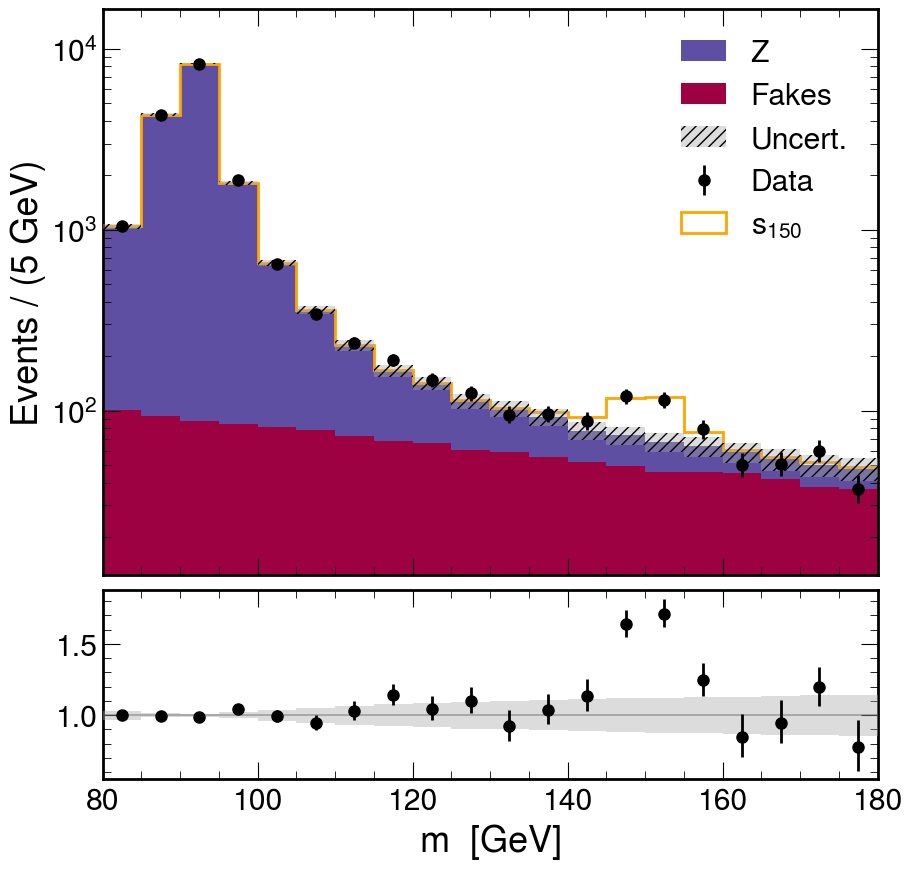

In [49]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data2,
                data_label=data_label,
                signals=[signals[i_signal_injected]],
                signal_labels=[signal_labels[i_signal_injected]],
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(x_min, x_max),
#                ylim=(10., 1e4),
                yscale='log',
                ratio=True)

(<Figure size 1000x1000 with 2 Axes>,
 [<AxesSubplot: ylabel='Events / (5 GeV)'>,
  <AxesSubplot: xlabel='$m$  [GeV]'>])

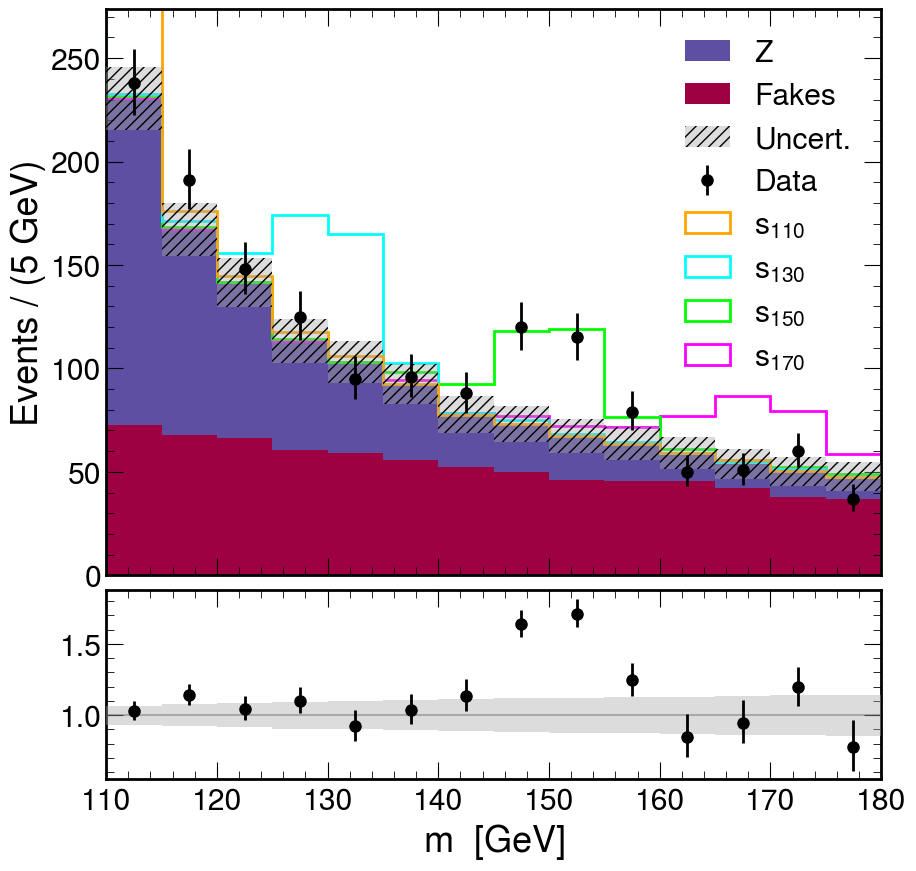

In [50]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data2,
                data_label=data_label,
                signals=signals[-max_signals_plotted:],
                signal_labels=signal_labels[-max_signals_plotted:],
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(110, 180),
#                ylim=(0.0, 160.0),
                ratio=True,
                stack_signals=True)

(<Figure size 1000x1000 with 2 Axes>,
 [<AxesSubplot: ylabel='Events / (5 GeV)'>,
  <AxesSubplot: xlabel='$m$  [GeV]'>])

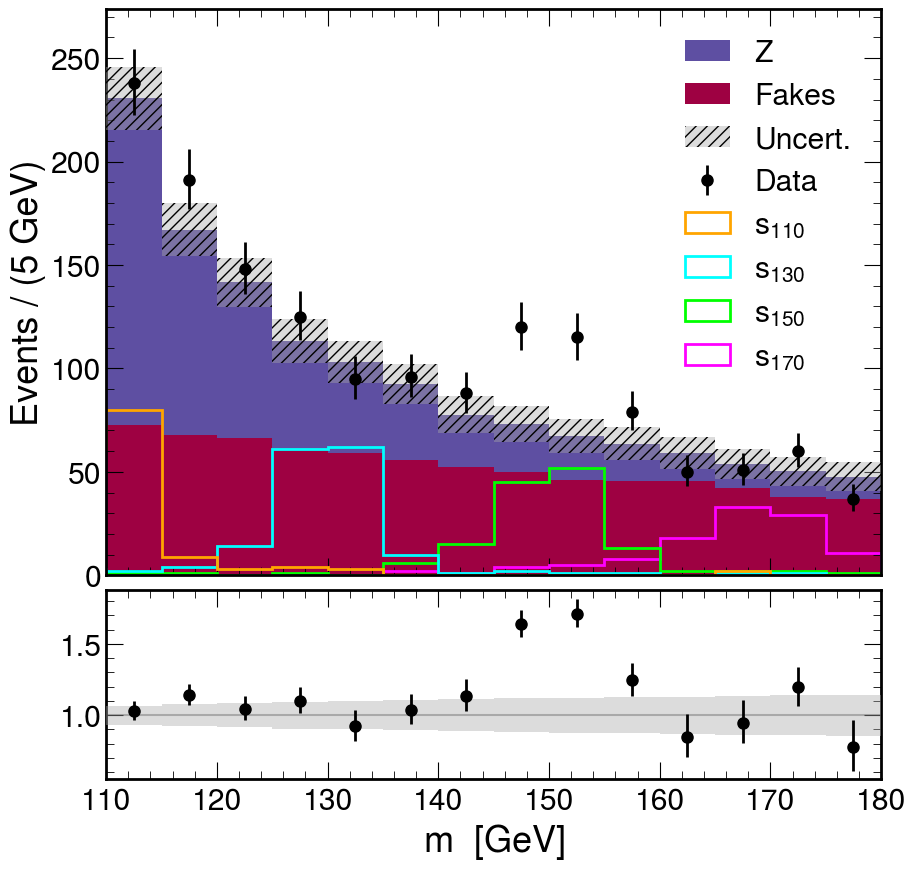

In [51]:
hep.plot.hist1d(bins, y,
                yerr=yerr,
                labels=labels,
                data=data2,
                data_label=data_label,
                signals=signals[-max_signals_plotted:],
                signal_labels=signal_labels[-max_signals_plotted:],
                xlabel=xlabel,
                ylabel=ylabel,
                xlim=(110, 180),
#                ylim=(0.0, 160.0),
                ratio=True,
                stack_signals=False)

In [ ]:
signal_ms, exclusions_exp, exclusions_obs = hep.stats.hypo_test_signal_scan(
        signal_grid=signal_grid,
        data=data2,
        bkg_data=ytotal,
        bkg_uncerts=yerr,
        mu_bounds=mu_bounds_excl,
        mu_step=mu_step_excl,
        test_size=test_size,
        )

In [ ]:
hep.plot.brazil(x=signal_ms, exp=exclusions_exp, obs=exclusions_obs,
                xlabel=r'$m$  [GeV]',
                ylabel=r'$\mu\ \mathrm{excluded\ at\ 95\%\ CL}$',
                yline=1.0)

## Calculate $p_0$ for discovery

In [ ]:
signal_ms, p0s_exp, p0s_obs = hep.stats.discovery_p0_signal_scan(
        signal_grid=signal_grid,
        data=data2,
        bkg_data=ytotal,
        bkg_uncerts=yerr)

In [ ]:
# drop 2-sigma bands, keep only 1-sigma
p0s_exp = [ band[1:4] for band in p0s_exp]

In [ ]:
hep.plot.brazil(x=signal_ms, exp=p0s_exp, obs=p0s_obs,
                xlabel=r'$m$  [GeV]',
                ylabel=r'Local $p_{0}$',
                ylim=(1e-7, 1.0),
                yscale='log',
                yline=[1.0-scipy.stats.norm.cdf(z) for z in [2, 3, 4, 5]],
                yline_label=[r'$%i\sigma$' % (z) for z in [2, 3, 4, 5]],
                fillstyle='gray')

## Measure best-fit signal strength

In [ ]:
example_signal = signal_grid[(150.0,)]
example_signal_pdf = hep.stats.make_pdf(bkg_data=ytotal, bkg_uncerts=yerr, signal_data=example_signal)

In [ ]:
twice_nlls, test_mus, mu_hat_band = hep.stats.twice_nll_mu_scan(
                   pdf=example_signal_pdf,
                   data=data2,
                   mu_bounds=mu_bounds_fit,
                   mu_step=mu_step_fit)

In [ ]:
hep.stats.plot_twice_nll(test_mus, twice_nlls,
              xlabel='$\mu$',
              ylabel='$-2 \Delta \mathrm{ln} \lambda(\mu)$',
              ylim=(0, 8),
              yline=1)

In [ ]:
signal_ms, mu_hat_results = hep.stats.signal_strength_signal_scan(
        signal_grid=signal_grid,
        data=data2,
        bkg_data=ytotal,
        bkg_uncerts=yerr)

In [ ]:
hep.plot.brazil(x=signal_ms, obs=mu_hat_results,
                xlabel=r'$m$  [GeV]',
                ylabel=r'Signal strength $(\hat{\mu})$',
                ylim=(-0.8, 2.0),
                yline=[0.0, 1.0],
                fillstyle='blue')

## See also

-   Cranmer, K. (2020). [Thumbnail of LHC statistical procedures](http://theoryandpractice.org/stats-ds-book/statistics/lhc_stats_thumbnail.html).
-   Cowan, G. et al. (2010). Asymptotic formulae for likelihood-based tests of new physics. https://arxiv.org/abs/1007.1727
-   https://pyhf.github.io/pyhf-tutorial/HelloWorld.html
-   Cranmer, K. et al. (2012). HistFactory: A tool for creating statistical models for use with RooFit and RooStats. CERN-OPEN-2012-016. <https://cds.cern.ch/record/1456844>
-   Heinrich, L., Feickert, M., & Stark, G. (2018). [pyhf](https://github.com/scikit-hep/pyhf). <https://scikit-hep.org/pyhf/>
-   Feickert, M. (2018). pyhf: a pure Python implementation of HistFactory with tensors and autograd. <https://indico.cern.ch/event/759480/>
-   <https://github.com/CoffeaTeam/coffea/blob/master/coffea/hist/plot.py>
-   <https://scikit-hep.org/pyhf/examples/notebooks/multichannel-coupled-histo.html>
-   <https://scikit-hep.org/pyhf/examples/notebooks/binderexample/StatisticalAnalysis.html>
-   <https://github.com/scikit-hep/mplhep/blob/master/src/mplhep/plot.py>

![](http://theoryandpractice.org/stats-ds-book/_images/LHC-stats-thumbnail.001.png)